In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("classic")
plt.rcParams.update({
    'font.family':'serif',
    'text.usetex':True
})
#cmapstr='Spectral'
#cmapstr='plasma'
cmapstr='RdYlBu'
%matplotlib notebook

## Function for Reading the STAT File

In [88]:
def read_data(filename, index):
    f = open(filename,"rb")

    ### Reading the header of the STAT File
    val,prec,ib,nb = np.fromfile(f,dtype='int32',count=4)
    nxp, nyp, nzp, ngp = np.fromfile(f,dtype='int32',count=4)
        
    for i in range(1,ngp+1):
        gid, nvar = np.fromfile(f,dtype='int32',count=2)
    nsamps, tstart, tend = np.fromfile(f,dtype='int32',count=3)
    tinterval = np.fromfile(f,dtype='float32',count=1)

    ### Reading in the data now
    coords = np.reshape(np.fromfile(f,dtype="float32",count=nxp*nyp*nzp*3),(nxp,nyp,nzp,3),order='F')
    skipindex = index
    f.seek(skipindex*nxp*nyp*nzp*4,1)
    var = np.reshape(np.fromfile(f,dtype="float32",count=nxp*nyp*nzp),(nxp,nyp,nzp),order='F')
    f.close()
    return var, coords, nxp, nyp, nzp, tinterval

In [4]:
varlist = [r"$\rho$", r"$U_z$", r"$U_r$", r"$T$", r"$p$"
           , r"$\mu$", r"\rho^{\prime}_{rms}", r"$T^{\prime \prime}_{rms}$"
          , r"$p^{\prime}_{rms}$", r"$\tau_{11}$", r"$\tau_{12}$",
          r"$\tau_{22}$", r"$\tau_{33}$", r"$\tau_{13}$"
           , r"$\tau_{23}$", r"$U_\theta$", r"$\mu_{sgs}$"]

## Define the time intervals and location of file

## 50k, TR = 1.0 Case

In [69]:
### Details of Files
time = "240-270"
#time = "280-320"
#time = "320-360"
#time = "360-390"
#time = "240-400"
wdir = ["/storage/clav/Postdoc/ph.m96.pulsed.Re50k/"]
sdir = ["ph.m96.pulsed.Re50k/"]

## Wall Parameter Extraction

In [72]:
#filename = wdir[0]+"post_pro/STAT_cont_m96_t"+time+".bin"
filename = wdir[0]+"post_pro/STAT_cont_m56_t"+time+".bin"

## Read the vars of interest!
rho, coords, nxp, nyp, nzp = read_data(filename, varlist.index(r"$\rho$"))
uz, coords, nxp, nyp, nzp = read_data(filename, varlist.index(r"$U_z$"))
ur, coords, nxp, nyp, nzp = read_data(filename, varlist.index(r"$U_r$"))
uth, coords, nxp, nyp, nzp = read_data(filename, varlist.index(r"$U_\theta$"))
mu, coords, nxp, nyp, nzp = read_data(filename, varlist.index(r"$\mu$"))

r = np.sqrt(coords[:,:,:,1]**2 + coords[:,:,:,2]**2)
z = coords[:,:,:,0]

u = np.sqrt((uz)**2 + (ur)**2 + (uth)**2)

## Calculated using net resultant of wall shear stress components, See Schilicting
u_star = np.sqrt((mu/rho)[0,:,:]*np.sqrt(
      ((ur[1,:,:]-ur[0,:,:])/(z[1,:,:]-z[0,:,:]))**2 +
      ((uth[1,:,:]-uth[0,:,:])/(z[1,:,:]-z[0,:,:]))**2
     ))
Re_tau = u_star*(rho/mu)[0,:,:]
uplus = np.zeros((nxp,nyp,nzp)); yplus = np.zeros((nxp,nyp,nzp))
for i in range(nxp):
    uplus[i,:,:] = np.sqrt((ur[i])**2 + (uth[i])**2)/(u_star[:,:]+1e-10)
    yplus[i,:,:] = u_star[:,:]*z[i,:,:]*rho[i,:,:]/mu[i,:,:]

from scipy.integrate import simps as sps
delta = np.zeros((nyp,nzp)); 
delta_r = np.zeros((nyp,nzp)); delta_th = np.zeros((nyp,nzp)); 
delta_star = np.zeros((nyp,nzp))
u_delta = np.zeros(np.shape(delta)); rho_delta = np.zeros(np.shape(delta))

u_net = np.sqrt(ur**2 + uth**2)
for k in range(nzp):
    for j in range(nyp):
        for i in range(nxp):
            if abs(u_net[i,j,k]) >= abs(u_net[i+1,j,k]):
                index = i
                break
        if index == 0 or Re_tau[j,k] == 0:
            delta[j,k] = 0.
        else:
            delta[j,k] = z[index,j,k] 
            delta_star[j,k] = sps(1 - rho[:index,j,k]*u_net[:index,j,k]/(rho[index,j,k]*u_net[index,j,k]),x=z[:index,j,k])
            u_delta[j,k] = u_net[index,j,k]
            rho_delta[j,k] = rho[index,j,k]

### Radial delta
for k in range(nzp):
    for j in range(nyp):
        for i in range(nxp):
            if abs(ur[i,j,k]) >= abs(ur[i+1,j,k]):
                index = i
                break
        if index == 0 or Re_tau[j,k] == 0:
            delta_r[j,k] = 0.
        else:
            delta_r[j,k] = z[index,j,k]

### Azimuthal delta
for k in range(nzp):
    for j in range(nyp):
        for i in range(nxp):
            if abs(uth[i,j,k]) >= abs(uth[i+1,j,k]):
                index = i
                break
        if index == 0 or Re_tau[j,k] == 0:
            delta_th[j,k] = 0.
        else:
            delta_th[j,k] = z[index,j,k]

Re_tau_alt = u_star*rho[0,:,:]/mu[0,:,:]*delta

<IPython.core.display.Javascript object>


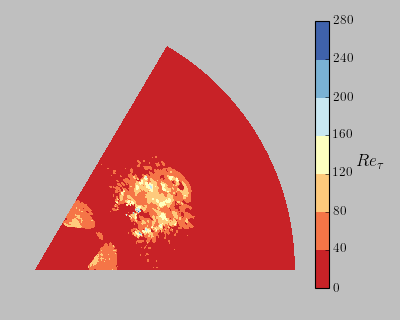

In [73]:
plt.figure(figsize=(5,4))
cba = plt.contourf(coords[0,:,:,2],coords[0,:,:,1],Re_tau_alt,cmap=cmapstr)
clb = plt.colorbar(cba)
clb.set_label(r'$Re_{\tau}$',fontsize=16,rotation=0,labelpad=15)
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_Retau_delta.pdf")
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_Retau_delta.png",dpi=600)

In [74]:
## Save Retau field
import csv
with open(sdir[0]+'data_ijhmt/t'+time+'_Retau.csv','w') as cf:
#with open('data/Retau.csv','w') as cf:
    fp = csv.writer(cf)
    fp.writerow(['nzp = '+str(nzp), 'nyp = '+str(nyp), 'Retau'])
    for k in range(nzp):
        for j in range(nyp):
            fp.writerow([str(coords[0,j,k,2]), str(coords[0,j,k,1]), str(Re_tau_alt[j,k])])

<IPython.core.display.Javascript object>


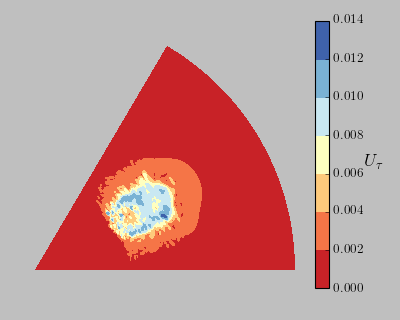

In [75]:
z_c = coords[1,:,:,2]; y_c = coords[1,:,:,1]
plt.figure(figsize=(5,4))
cba = plt.contourf(z_c, y_c,u_star,cmap=cmapstr)
clb = plt.colorbar(cba)
clb.set_label(r"$U_\tau$",fontsize=16,rotation=0,labelpad=10)
plt.axis('off')
plt.axis('equal')
#plt.xlim(10,30)
#plt.ylim(10,20)
plt.tight_layout()
plt.savefig(sdir[0]+'figures_ijhmt/t'+time+'_utau.pdf')
plt.savefig(sdir[0]+'figures_ijhmt/t'+time+'_utau.png',dpi=600)

## Save Retau field
import csv
with open(sdir[0]+'data_ijhmt/t'+time+'_utau.csv','w') as cf:
    fp = csv.writer(cf)
    fp.writerow(['nzp = '+str(nzp), 'nyp = '+str(nyp), 'u_tau'])
    for k in range(nzp):
        for j in range(nyp):
            fp.writerow([str(coords[0,j,k,2]), str(coords[0,j,k,1]), str(u_star[j,k])])

In [76]:
utau_threshold = 0.0025

## Plus Values of Near Wall

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


(12.657979501681588, 57.15373449133667)


<IPython.core.display.Javascript object>


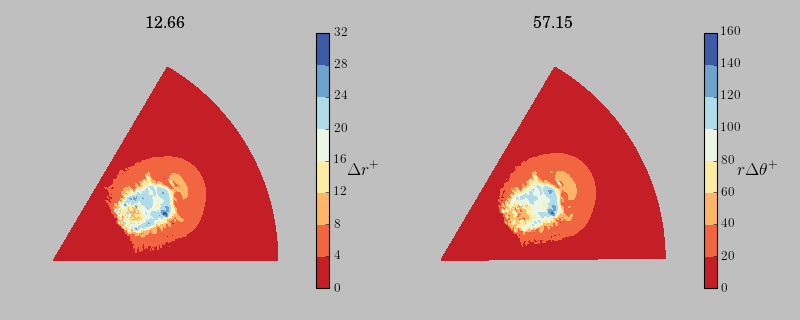

In [77]:
## Cylindrical coordinates
theta = np.arctan(coords[...,1]/coords[...,2])

## Plus Value Ranges
rplus = [(r[0,j+1,:]-r[0,j,:])*u_star[j,:]*rho[0,j,:]/mu[0,j,:] for j in range(nyp-1)]
dthplus = [(theta[0,:,j+1]-theta[0,:,j])*r[0,:,j]*u_star[:,j]*rho[0,:,j]/mu[0,:,j] for j in range(nzp-1)]

count = 0; val = 0; val1 = 0
for k in range(nzp-1):
    for j in range(1,nyp):
        if u_star[j,k] > utau_threshold:
            count = count + 1
            val = val + rplus[j][k]
            val1 = val1 + dthplus[k][j]
print(val/count, val1/count)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(str(round((val/count),2)))
cba = plt.contourf(coords[0,1:,:,2],coords[0,1:,:,1],rplus,cmap=cmapstr)
clb = plt.colorbar(cba)
clb.set_label(r'$\Delta r^+$',fontsize=16,rotation=0,labelpad=15)
plt.axis('off')
plt.axis('equal')
plt.subplot(1,2,2)
plt.title(str(round((val1/count),2)))
cba = plt.contourf(coords[0,:,1:,2],coords[0,:,1:,1],np.transpose(dthplus),cmap=cmapstr)
clb = plt.colorbar(cba)
clb.set_label(r'$r \Delta \theta^+$',fontsize=16,rotation=0,labelpad=15)
plt.axis('off')
plt.axis('equal')

plt.tight_layout()
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_delta-rthplus.pdf")
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_delta-rthplus.png",dpi=600)

## BL Growth: Radially, Azimuthally and Total

In [78]:
## Total BL thickness growth radially and azimuthally, averaged

growth_r = np.zeros(np.shape(delta[:,0]))
growth_th = np.zeros(np.shape(delta[0,:]))

for j in range(nyp):
    count = 0.
    for k in range(nzp):
        if u_star[j,k] > utau_threshold:
            count = count + 1
            growth_r[j] = growth_r[j] + delta[j,k]
    growth_r[j] = growth_r[j]/count

for k in range(nzp):
    count = 0.
    for j in range(nyp):
        if u_star[j,k] > utau_threshold:
            count = count + 1
            growth_th[k] = growth_th[k] + delta[j,k]
    growth_th[k] = growth_th[k]/count

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


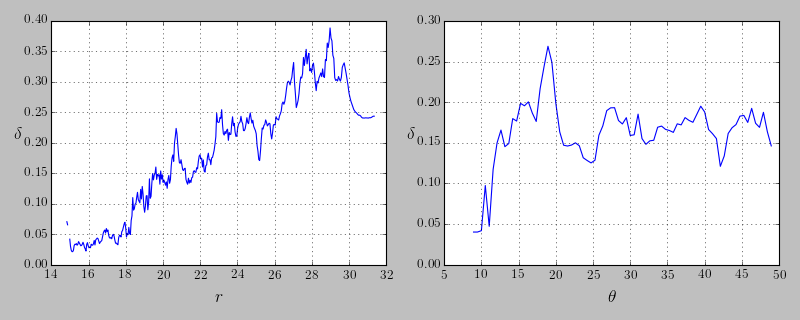

In [79]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(r[0,:,int(nzp/2)], growth_r)
plt.xlabel(r"$r$",fontsize=16)
plt.ylabel(r"$\delta$",fontsize=16,rotation=0)
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(theta[1,1,:]*180./np.pi, growth_th)
plt.xlabel(r"$\theta$",fontsize=16,rotation=0)
plt.ylabel(r"$\delta$",fontsize=16,rotation=0)
plt.grid(True)
plt.tight_layout()
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_BLgrowth.pdf")
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_BLgrowth.png",dpi=600)

import csv
with open(sdir[0]+'data_ijhmt/t'+time+'_growth_rate_r_delta.csv','w') as cf:
    fp = csv.writer(cf)
    fp.writerow(['nyp = '+str(nyp), 'growth_r'])
    for j in range(nyp):
        fp.writerow([str(r[0,j,int(nzp/2)]), str(growth_r[j])])
with open(sdir[0]+'data_ijhmt/t'+time+'_growth_rate_th_delta.csv','w') as cf:
    fp = csv.writer(cf)
    fp.writerow(['nyp = '+str(nyp), 'growth_th'])
    for k in range(nzp):
        fp.writerow([str(theta[1,1,k]), str(growth_th[k])])

In [80]:
### Growth Rates in radial and azimuthal directions
## Radial BL thickness in radial direction and azimuthal BL thickness in azimuthal direction
growth_r = np.zeros(np.shape(delta_r[:,0]))
growth_th = np.zeros(np.shape(delta_th[0,:]))

for j in range(nyp):
    count = 0.
    for k in range(nzp):
        if u_star[j,k] > utau_threshold:
            count = count + 1
            growth_r[j] = growth_r[j] + delta_r[j,k]
    growth_r[j] = growth_r[j]/count

for k in range(nzp):
    count = 0.
    for j in range(nyp):
        if u_star[j,k] > utau_threshold:
            count = count + 1
            growth_th[k] = growth_th[k] + delta_th[j,k]
    growth_th[k] = growth_th[k]/count

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


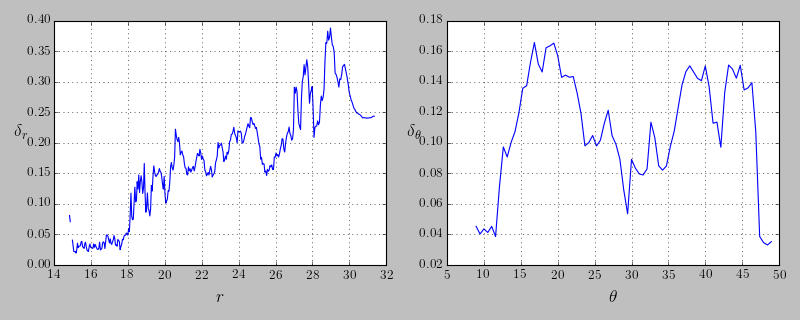

In [81]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(r[0,:,int(nzp/2)], growth_r)
plt.xlabel(r"$r$",fontsize=16)
plt.ylabel(r"$\delta_r$",fontsize=16,rotation=0)
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(theta[1,1,:]*180./np.pi, growth_th)
plt.xlabel(r"$\theta$",fontsize=16,rotation=0)
plt.ylabel(r"$\delta_\theta$",fontsize=16,rotation=0)
plt.grid(True)
plt.tight_layout()
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_BLgrowth_rth.pdf")
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_BLgrowth_rth.png",dpi=600)

import csv
with open(sdir[0]+'data_ijhmt/t'+time+'_growth_rate_r_delta_r.csv','w') as cf:
    fp = csv.writer(cf)
    fp.writerow(['nyp = '+str(nyp), 'growth_r'])
    for j in range(nyp):
        fp.writerow([str(r[0,j,int(nzp/2)]), str(growth_r[j])])
with open(sdir[0]+'data_ijhmt/t'+time+'_growth_rate_th_delta_th.csv','w') as cf:
    fp = csv.writer(cf)
    fp.writerow(['nyp = '+str(nyp), 'growth_th'])
    for k in range(nzp):
        fp.writerow([str(theta[1,1,k]), str(growth_th[k])])

## Plus Profiles for Momentum BL

### Averaged $Re_\tau$ Range

In [82]:
from scipy.interpolate import interp1d

for ll in range(200,700,100):
    uavg = np.zeros((nxp)); yavg = np.zeros((nxp)); count = 0
    low = ll
    upp = ll + 100
    for k in range(nzp):
        for j in range(nyp):
            if Re_tau_alt[j,k] >= low and Re_tau_alt[j,k] < upp:
                f = interp1d(yplus[:, j, k], uplus[:, j, k])
                yp_equi = np.logspace(-1,3,num=nxp,endpoint=True)
                up_equi = f(yp_equi)
                uavg[:] = uavg[:] + up_equi
                yavg[:] = yavg[:] + yp_equi
                
                #uavg[:] = uavg[:] + uplus[:,j,k]
                #yavg[:] = yavg[:] + yplus[:,j,k]       
                count = count + 1
    uavg = uavg/count; yavg = yavg/count
    print(count)
    kappa = 0.41; B = 5.0
    plt.figure(figsize=(5,4))
    plt.semilogx(yavg[:],uavg[:],linewidth=2,label='Data')
    plt.semilogx(np.linspace(1,100),np.linspace(1,100),'k--',label=r'$U^+=z^+$')
    plt.semilogx(yavg[:], 1/kappa*np.log(yavg[:]) + B
             ,'k--',label=r'$U^+=\frac{1}{\kappa} \log(z^+) + B$')
    plt.xlabel(r'$z^+$',fontsize=16)
    plt.ylabel(r'$U^+$',rotation=0,fontsize=16)
    plt.xlim(1,1000)
    plt.ylim(0,20)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(wdir[0]+'figures/t'+time+'_vrth+_Retau'+str(low)+'-'+str(upp)+'.pdf')
    plt.savefig(wdir[0]+'figures/t'+time+'_vrth+_Retau'+str(low)+'-'+str(upp)+'.png',dpi=600)
    
    ## Save data
    with open(wdir[0]+'data/t'+time+'_vrth+_Retau'+str(low)+'-'+str(upp)+'.csv','w') as cf:
    #with open('../data/vrth+_Retaualt'+str(low)+'-'+str(upp)+'_log.csv','w') as cf:
        fp = csv.writer(cf)
        fp.writerow(['averaging points = '+str(count)])
        fp.writerow(['u+', 'y+'])
        for i in range(nxp):
            fp.writerow([str(uavg[i]), str(yavg[i])])

### Profiles averaged over $U_\tau$ range

<IPython.core.display.Javascript object>


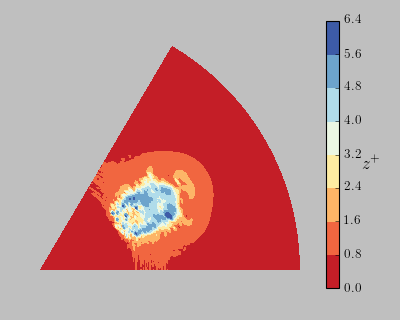

<IPython.core.display.Javascript object>


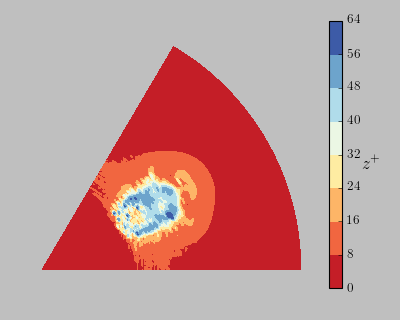

<IPython.core.display.Javascript object>


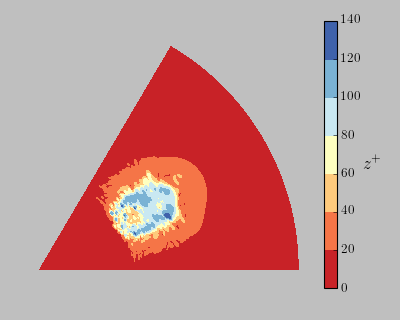

In [83]:
z_c = coords[1,:,:,2]; y_c = coords[1,:,:,1]
for pp in [1,10,20]:
    plt.figure(figsize=(5,4))
    cba = plt.contourf(z_c,y_c,yplus[pp,...],cmap=cmapstr)
    clb = plt.colorbar(cba)
    clb.set_label(r"$z^+$",rotation=0,fontsize=16,labelpad=10)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_zplus_i"+str(pp)+".pdf")
    plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_zplus_i"+str(pp)+".png",dpi=600)

16947


<IPython.core.display.Javascript object>


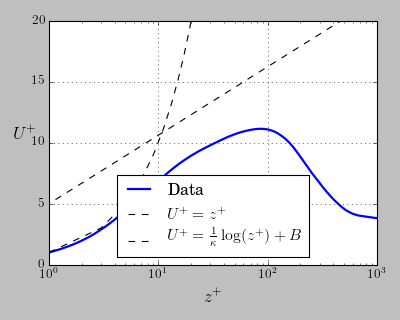

In [84]:
### Profile based on the jet footprint only!
from scipy.interpolate import interp1d
uavg = np.zeros((nxp)); yavg = np.zeros((nxp)); count = 0
for k in range(nzp):
    for j in range(nyp):
        if u_star[j,k] > utau_threshold:
            f = interp1d(yplus[:, j, k], uplus[:, j, k])
            yp_equi = np.logspace(-1,3,num=nxp,endpoint=True)
            up_equi = f(yp_equi)
            uavg[:] = uavg[:] + up_equi
            yavg[:] = yavg[:] + yp_equi

            count = count + 1
uavg = uavg/count; yavg = yavg/count
print(count)
kappa = 0.41; B = 5.0
plt.figure(figsize=(5,4))
plt.semilogx(yavg[:],uavg[:],linewidth=2,label='Data')
plt.semilogx(np.linspace(1,100),np.linspace(1,100),'k--',label=r'$U^+=z^+$')
plt.semilogx(yavg[:], 1/kappa*np.log(yavg[:]) + B
         ,'k--',label=r'$U^+=\frac{1}{\kappa} \log(z^+) + B$')
plt.xlabel(r'$z^+$',fontsize=16)
plt.ylabel(r'$U^+$',rotation=0,fontsize=16)
plt.xlim(1,1000)
plt.ylim(0,20)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_vrth+_overall.pdf")
plt.savefig(sdir[0]+"figures_ijhmt/t"+time+"_vrth+_overall.png",dpi=600)

## Save data
with open(sdir[0]+'data_ijhmt/t'+str(time)+'_vrth+_overall.csv','w') as cf:
    fp = csv.writer(cf)
    fp.writerow(['averaging points = '+str(count)])
    fp.writerow(['u+', 'y+'])
    for i in range(nxp):
        fp.writerow([str(uavg[i]), str(yavg[i])])

### Profiles at fixed locations

('Index', 573)
('Count', 81)


<IPython.core.display.Javascript object>


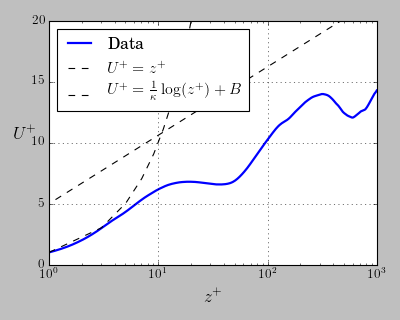

('Index', 685)
('Count', 81)


<IPython.core.display.Javascript object>


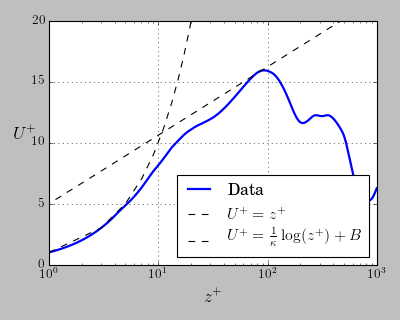

('Index', 788)
('Count', 81)


<IPython.core.display.Javascript object>


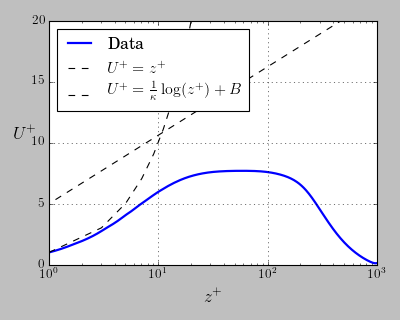

In [85]:
positions = [20, 25, 30]
rgrid = np.loadtxt(wdir[0]+"r_grid_1.dat",skiprows=1)

for ll in range(len(positions)):
    uavg = np.zeros((nxp)); yavg = np.zeros((nxp)); count = 0
    
    jind = np.argmin(abs(positions[ll] - rgrid))
    print("Index",jind)
    
    for k in range(int(nzp/2) - 4, int(nzp/2) + 5):
        for j in range(jind-4, jind+5):
            f = interp1d(yplus[:, j, k], uplus[:, j, k])
            #print(np.max(yplus[:,j,k]))
            yp_equi = np.logspace(-1,3,num=nxp,endpoint=True)
            up_equi = f(yp_equi)
            uavg[:] = uavg[:] + up_equi
            yavg[:] = yavg[:] + yp_equi

            count = count + 1
    uavg = uavg/count; yavg = yavg/count
    print("Count",count)
    kappa = 0.41; B = 5.0
    plt.figure(figsize=(5,4))
    plt.semilogx(yavg[:],uavg[:],linewidth=2,label='Data')
    plt.semilogx(np.linspace(1,100),np.linspace(1,100),'k--',label=r'$U^+=z^+$')
    plt.semilogx(yavg[:], 1/kappa*np.log(yavg[:]) + B
             ,'k--',label=r'$U^+=\frac{1}{\kappa} \log(z^+) + B$')
    plt.xlabel(r'$z^+$',fontsize=16)
    plt.ylabel(r'$U^+$',rotation=0,fontsize=16)
    plt.xlim(1,1000)
    plt.ylim(0,20)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(sdir[0]+'figures_ijhmt/t'+time+'_vrth+_r'+str(positions[ll])+'th30.pdf')
    plt.savefig(sdir[0]+'figures_ijhmt/t'+time+'_vrth+_r'+str(positions[ll])+'th30.png',dpi=600)
    
    ## Save data
    with open(sdir[0]+'data_ijhmt/t'+time+'_vrth+_r'+str(positions[ll])+'th30.csv','w') as cf:
        fp = csv.writer(cf)
        fp.writerow(['averaging points = '+str(count)])
        fp.writerow(['u+', 'y+'])
        for i in range(nxp):
            fp.writerow([str(uavg[i]), str(yavg[i])])